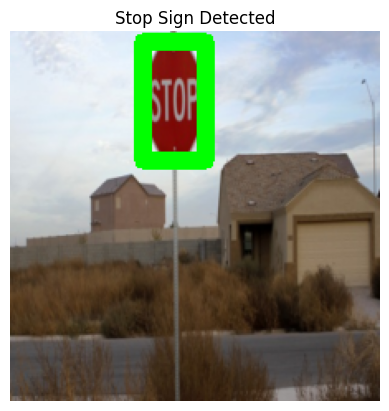

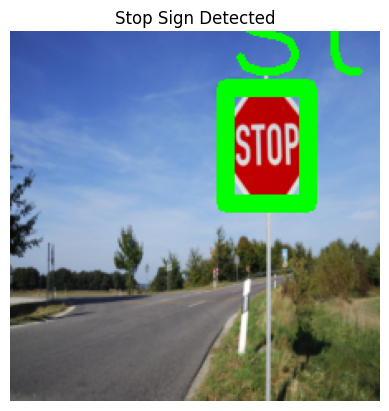

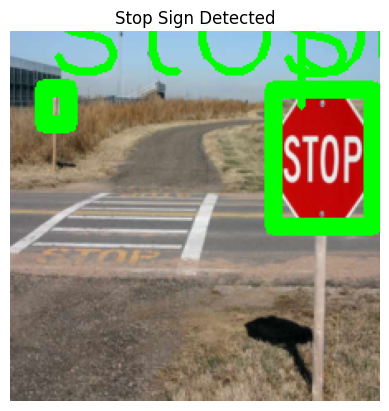

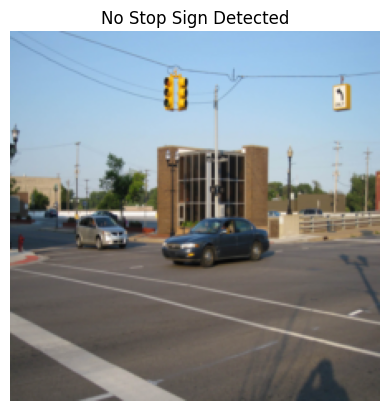

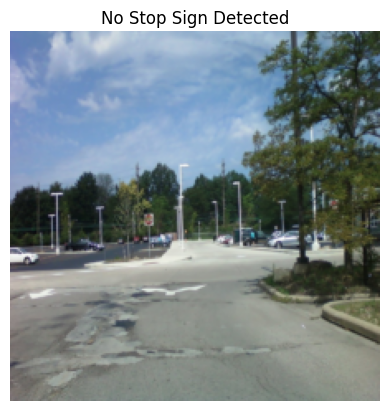

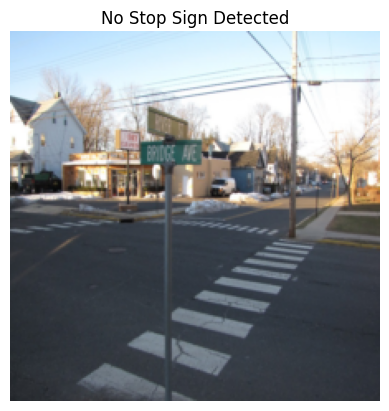

In [5]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Load the pre-trained Faster R-CNN model
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()  # Set the model to evaluation mode

def get_predictions(pred, threshold=0.8, objects=None):
    """
    Filter predictions based on a probability threshold and specific object classes.

    Args:
        pred: Output from the model, contains detected objects' info.
        threshold: Minimum probability to consider a prediction valid.
        objects: List of object names to filter predictions by.

    Returns:
        Filtered predictions as a list of tuples.
    """
    predicted_classes = [
        (COCO_INSTANCE_CATEGORY_NAMES[i], p, box.detach().numpy())  # Extract box directly as a numpy array
        for i, p, box in zip(pred[0]['labels'].numpy(), 
                             pred[0]['scores'].detach().numpy(), 
                             pred[0]['boxes'])
    ]
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    if objects and predicted_classes:
        predicted_classes = [(name, p, box) for name, p, box in predicted_classes if name in objects]
    
    return predicted_classes

def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    """
    Draw bounding boxes around detected objects and indicate presence of stop signs.

    Args:
        predicted_classes: List of predicted classes with bounding box information.
        image: Image to draw the bounding boxes on.
    """
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    
    stop_sign_detected = False  # Flag to check if a stop sign is detected

    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2].astype(int)  # Ensure box coordinates are integers

        # Draw Rectangle and label with probability
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), rect_th)
        cv2.putText(img, f"{label}: {round(probability, 2)}", (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

        # Check if the detected class is 'stop sign'
        if label == "stop sign":
            stop_sign_detected = True

    # Add final prediction label to the image
    final_label = "Stop Sign Detected" if stop_sign_detected else "No Stop Sign Detected"
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(final_label)  # Show prediction title
    plt.axis('off')
    plt.show()

def model(x):
    """Run the model and get predictions."""
    with torch.no_grad():
        return model_(x)

# Load images and predict
image_names = [
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/stop/1.jpg',
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/stop/2.jpg',
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/stop/3.jpg',
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/not_stop/105.jpg',
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/not_stop/106.jpg',
    '/Users/joanmascastella/Desktop/CODE/IBM_AI_Engineering/Labs/not_stop/107.jpg'
]

# Image transformation
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

for image_name in image_names:
    image = Image.open(image_name).convert("RGB")
    x = transform(image).unsqueeze(0)  # Add batch dimension
    z = model(x)

    predicted_classes = get_predictions(z, objects=["stop sign"])
    draw_box(predicted_classes, x[0])  # Pass the image without batch dimension